In [1]:
import numpy as np
import cv2 as cv
import scipy.io
from matplotlib import pyplot as plt

#Triangulation and Essential Matrix Functions

In [2]:
def triangulate_point(ptsl,ptsr,Pl,Pr):
    """ Point pair triangulation from
    least squares solution. """
    M = np.zeros((6,6))
    M[:3,:4] = Pl
    M[3:,:4] = Pr
    M[:3,4] = -ptsl
    M[3:,5] = -ptsr
    U,S,V = np.linalg.svd(M)
    X = V[-1,:4]
    return X / X[3]

def triangulate(ptsl,ptsr,Pl,Pr):
    """ Two-view triangulation of points in
    x1,x2 (3*n homog. coordinates). """

    n = ptsl.shape[1]
    if ptsr.shape[1] != n:
      raise ValueError("Number of points don't match.")

    X = [ triangulate_point(ptsl[:,i],ptsr[:,i],Pl,Pr) for i in range(n)]

    return np.array(X).T


def calculate_4solutions(E):
# Calculate the four possible solutions
    #print("E: \n", E)

    # Rotation matrix around the Z-axis of pi/2 radians
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])

    # SVD of the Essential Matrix
    U,S,Vt = np.linalg.svd(E)

    if np.linalg.det(np.dot(U,Vt))<0:
        Vt = -Vt
    # Compute the four possible solutions
    # Two options for rotation:
    #    * R = U·W·Vt
    #    * R = U·W^T·Vt

    # Two option for translation: T and -T
    # T = U and -T = -U

    RT = [np.vstack((np.dot(U,np.dot(W,Vt)).T,U[:,2])).T,
          np.vstack((np.dot(U,np.dot(W,Vt)).T,-U[:,2])).T,
          np.vstack((np.dot(U,np.dot(W.T,Vt)).T,U[:,2])).T,
          np.vstack((np.dot(U,np.dot(W.T,Vt)).T,-U[:,2])).T]

    #print('Print the four solutions:\n')
    #print(RT[0] ,'\n')
    #print(RT[1] ,'\n')
    #print(RT[2] ,'\n')
    #print(RT[3] ,'\n')

    return RT

def select_solution (ptsl,ptsr,Pl,Pr):

    # pick the solution with points in front of cameras
    ind = 0
    maxres = 0
    for i in range(4):
      # triangulate inliers and compute depth for each camera
      X = triangulate(ptsl,ptsr,Pl,Pr[i])
      d1 = np.dot(Pl,X)[2]
      d2 = np.dot(Pr[i],X)[2]

      if (np.sum(d1>0)+np.sum(d2>0)) > maxres:
          maxres = np.sum(d1>0)+np.sum(d2>0)
          ind = i
          infront = (d1>0) & (d2>0)

    Tfinal = Pr[ind][:,3]
    Rfinal = Pr[ind][:,0:3]

    return ind, Tfinal, Rfinal

#Example

In [3]:
def case_one():
    # Read images
    imgl = cv.imread('img_left.jpg')  #queryimage # left image
    imgr = cv.imread('img_right.jpg') #trainimage # right image

    # intrinsic parameter matrix

    # for the right camera
    Kr = np.array([[ 857.1590, 0, 318.2537],[0, 860.8839, 233.3245],[0, 0, 1.0000]])

    # for the left camera
    Kl = np.array([[855.3492, 0, 319.2672],[0, 859.2368, 247.6019],[0, 0, 1.0000]])


    # Read points that were collected manually
    data = scipy.io.loadmat('selected_points.mat')

    ptsl = data['npt0']
    ptsr = data['npt1']

    # compute image coordinates in metric
    Kl_inv = np.linalg.inv(Kl)
    Kr_inv = np.linalg.inv(Kr)

    lin,npoints = ptsl.shape

    ptsl_m = np.dot(Kl_inv,np.vstack((ptsl,np.ones((1,npoints)))))
    ptsr_m = np.dot(Kr_inv,np.vstack((ptsr,np.ones((1,npoints)))))

    # cv.FM_8POINT + cv.FM_RANSAC
    pts1 = ptsl_m[0:2,:].T
    pts2 = ptsr_m[0:2,:].T

    # Estimate the Fundamental matrix
    # cv.FM_8POINT + cv.FM_RANSAC
    #E, mask = cv.findFundamentalMat(pts1,pts2,cv.RANSAC,0.1,0.9999999)
    E, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_8POINT,0.1,0.9999999)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    # Calculate the four possible solutions
    RT = calculate_4solutions(E)
    P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

    ind_test,T_test,R_test = select_solution (ptsl_m,ptsr_m,P1,RT)
    P2 = RT[ind_test]

    return imgl,imgr,ptsl,ptsr,ptsl_m,ptsr_m,P1,P2,


#Main

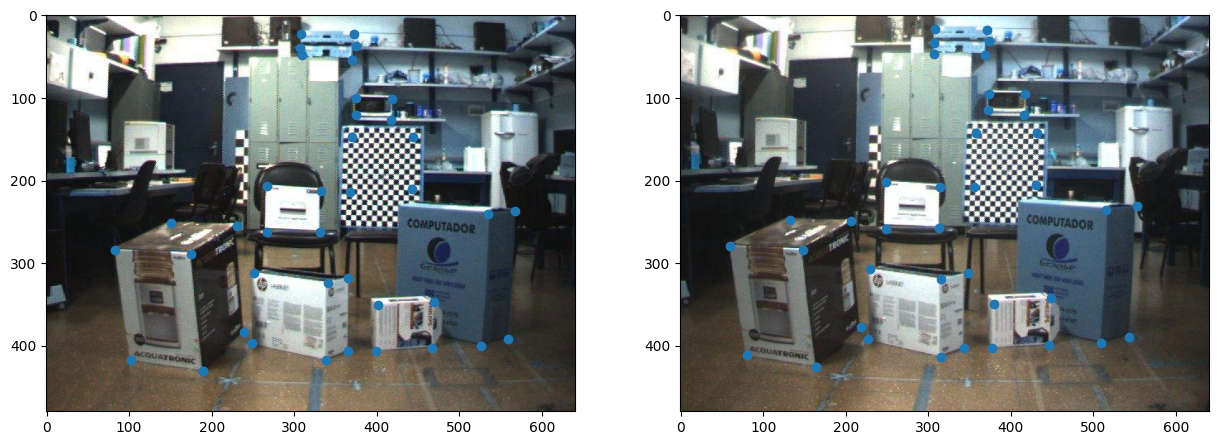

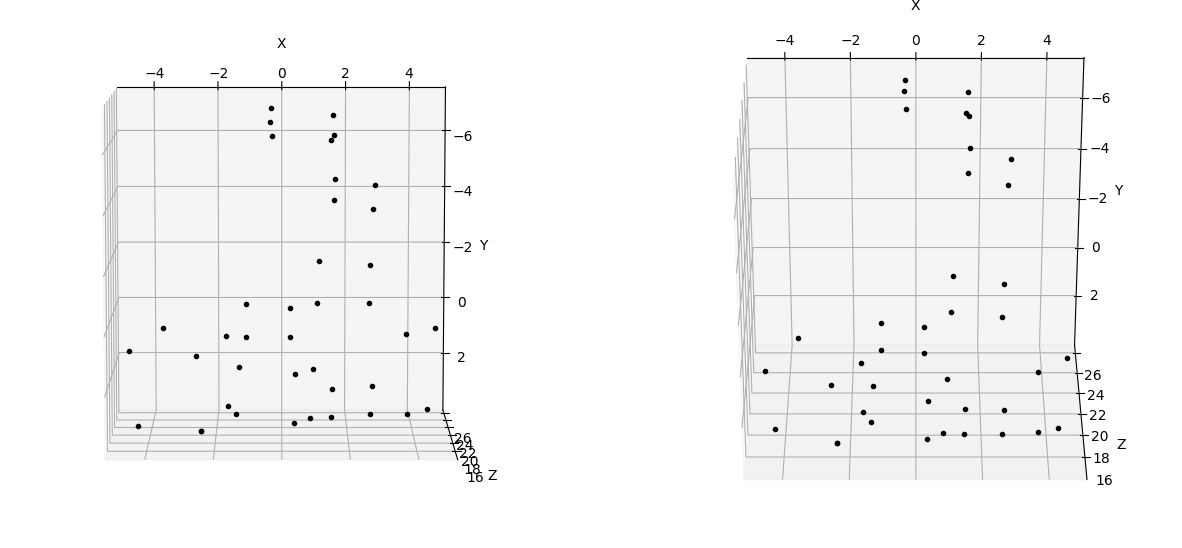

In [4]:
CASE = 1

if CASE == 1:
    img_left,img_right,pts_left,pts_right,ptsl_m,ptsr_m,Pl,Pr = case_one()
    Xest = triangulate(ptsl_m,ptsr_m,Pl,Pr)


# plotting
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img_left)
plt.plot(pts_left[0,:],pts_left[1,:],'o')
plt.subplot(122)
plt.imshow(img_right)
plt.plot(pts_right[0,:],pts_right[1,:],'o')


fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot(Xest[0],Xest[1],Xest[2],'k.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=-82,azim=-90)
ax1 = fig.add_subplot(1,2,2, projection='3d')
ax1.plot(Xest[0],Xest[1],Xest[2],'k.')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(elev=-60,azim=-90)
